In [1]:
import plot_tools

import importlib

importlib.reload(plot_tools)

<module 'plot_tools' from '/home/bill/GitHub/wps-research/data/bill/plot_tools.py'>

In [2]:
import matplotlib.pyplot as plt
from plot_tools import plot
import numpy as np

In [3]:
from raster import Raster
from misc.general import htrim_3d

**data filename**

In [4]:
burn_mask_file = 'mapped_burn/1009.bin_classified.bin'

image_file = 'fire_C11659/S2C_MSIL2A_20250609T192931_N0511_R142_T09UYU_20250610T002612_cloudfree.bin_MRAP_C11659.bin'

**The mask**

We used algorithm to find the best burn mapping (not completely automatic).

In [5]:
burn_mask = Raster(burn_mask_file)

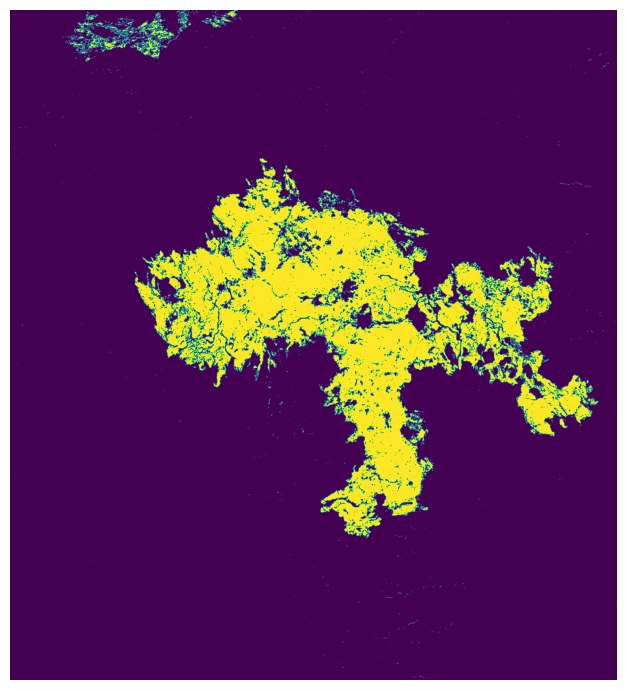

In [6]:
burn_mask_dat = burn_mask.read_bands('all').squeeze()

plot(burn_mask_dat, figsize=(7,7))

In [7]:
burn_mask_dat = burn_mask_dat.astype(np.bool_)

**The focused fire**

In [8]:
image = Raster(image_file)
image_dat = image.read_bands('all')

In [9]:
for i, name in enumerate(image.band_info_list):
    print(i + 1, name)

1 MSIL2A 20m: B12 2190nm
2 MSIL2A 20m: B11 1610nm
3 MSIL2A 60m: B9 945nm
4 MSIL2A 10m: B8 842nm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/lib/python3/dist-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


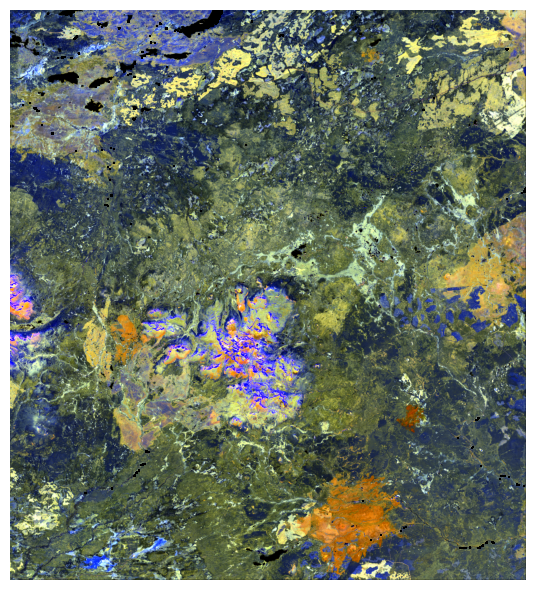

In [10]:
plot(
    htrim_3d(image_dat[..., :3]), figsize=(6,6)
)

**Function to densify**

In [11]:
band_names = [
    'B12 SWIR',
    'B11 SWIR',
    'B9 Water Vapour',
    'B8 NIR'
]

In [22]:
def densify_polygon(
    dat,
    mask,
    band_index,
    *,
    ax=None
):

    data = dat[..., band_index - 1]
    inside = data[mask]
    outside = data[~mask]

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    else:
        fig = ax.figure

    ax.hist(
        outside,
        density=True,
        color="blue",
        alpha=0.6,
        bins=200,
        label="Unburned"
    )
    ax.hist(
        inside,
        density=True,
        color="red",
        alpha=0.6,
        bins=200,
        label="Burned"
    )

    ax.set_xlim(0, 5000)
    ax.set_yticks([])

    #Mean values
    mean_in = np.nanmean(inside)
    mean_out = np.nanmean(outside)
    ax.set_title(f'{band_names[band_index - 1]} | Means in:{mean_in:.1f}, out:{mean_out:.1f}')

    return fig, ax

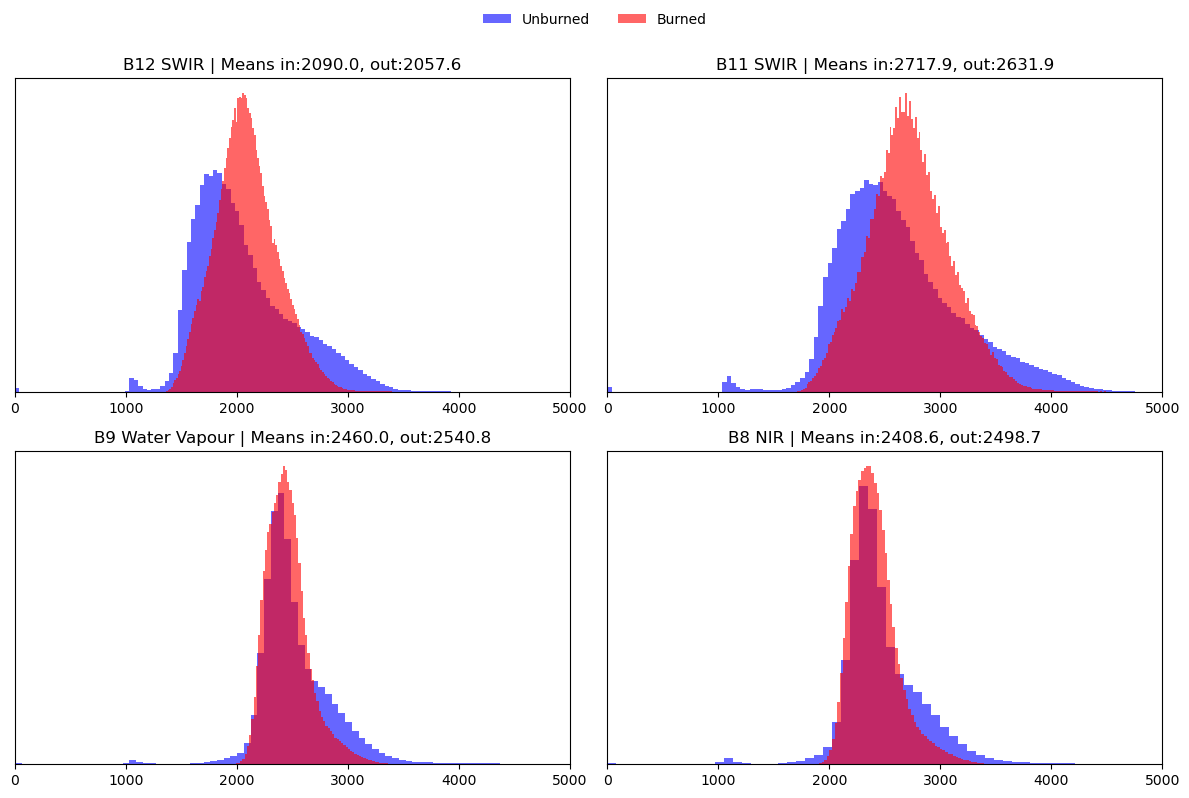

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, band_idx in enumerate([1, 2, 3, 4]):
    densify_polygon(
        image_dat,
        burn_mask_dat,
        band_index=band_idx,
        ax=axes[i]
    )

# grab legend handles from any axis
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    frameon=False
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Hypothesis testing**

Notice that, there is an overlap in the range of the data. Even though the means can be different (a bit), it can be due to many reasons. For that, we need a proper test to see:

    Do the means equate by chance?